### Project: Analyze fluctuations in HTTP request latency data to determine reliability

Appendix:
- Prepare data:
	- Create sample data from script (data has interval time is 30 second)
- Analyze data
	- Load data (.csv) to dataframe
	- Standardize data
	    - Set index for dataframe is timestamp
	- Explore data
        - Analyze fluctuations on the dataset
		- Apply pct_change (relative change) for good fluctuations observer 
    - SLI Calculator
        - Simulator rate() on rolling windows
        - Calculate percentile: [50th, 90th, 95th, 99th] or latency in time vector
	
- Apply model

In [118]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

In [119]:
BUCKETS = [0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]

In [120]:
# Load dataset from CSV file
root = pd.read_csv('../statics/csv/request_data_with_anomaly_pod_instance.csv', index_col=0)

In [121]:
# Convert to datetime pandas and set datetime columns is index for dataframe
root.index = pd.to_datetime(root.index)
root.head()

,path,method,service_name,controller_pod,0.005,0.01,0.025,0.05,0.1,0.25,0.5,+Inf
timestamp,,,,,,,,,,,,
2024-01-02 10:42:00,/home,GET,process_log,pod-1,0,0,0,0,0,1,1,1
2024-01-02 10:42:00,/home,GET,process_log,pod-2,0,0,0,0,0,0,1,2
2024-01-02 10:42:00,/users,GET,process_log,pod-1,0,0,0,0,1,2,3,5
2024-01-02 10:42:00,/users,GET,process_log,pod-2,0,0,0,0,0,0,2,3
2024-01-02 10:42:30,/home,GET,process_log,pod-1,0,0,0,0,1,8,12,21


In [122]:
grouped = ['service_name', 'controller_pod', 'path', 'method']

### Analyze fluctuations on the dataset

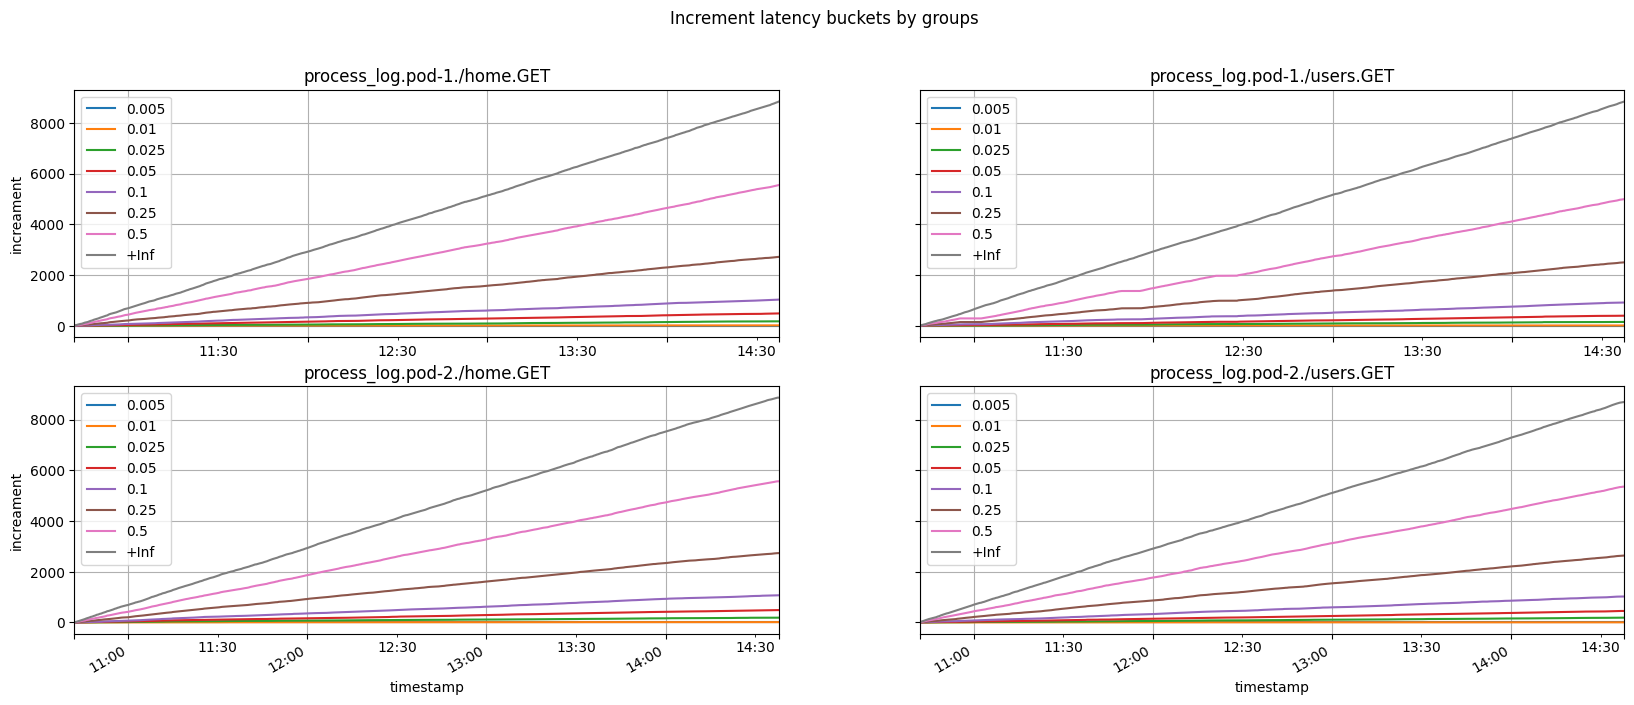

In [123]:
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
chart_data = root.groupby(grouped)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 8), sharey=True)
fig.suptitle('Increment latency buckets by groups')
# Configure x-axis date ticks
locator = AutoDateLocator(minticks=5, maxticks=10)
formatter = AutoDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
for (name, df), ax in zip(chart_data, axes.flat):
    name = ".".join(list(name))
    df.plot(kind="line", ax=ax, title=name, grid=True)
    ax.set(xlabel='timestamp', ylabel='increament')

plt.gcf().autofmt_xdate()
plt.show()

Kết quả cho thấy tăng trưởng trên mối bucket của các group rất đồng đều. Nhưng ở group **process_log.pod-1./users.GET** có 2 đoạn thời gian chỉ tăng trưởng đối với bucket +Inf, còn các bucket khác đều không có tăng trưởng gì. **Điều này chứng tỏ trong 2 khoảng thời gian này có những requests chỉ rơi vào các bucket *+Inf* (nghĩa là duration_time của các requests trong khoảng này đa số nằm trong ngưỡng > 500ms)**

-> Khoảng thời gian có requests chứa duration_time > 500ms: ['2024-01-02 11:00:00', '2024-01-02 12:30:00']

In [124]:
abnormal_group = "path == '/users' and controller_pod == 'pod-1'"
abnormal_timerange_in_group = ['2024-01-02 11:00:00', '2024-01-02 12:30:00']

### Apply pct_change (relative change) for good fluctuations observer 

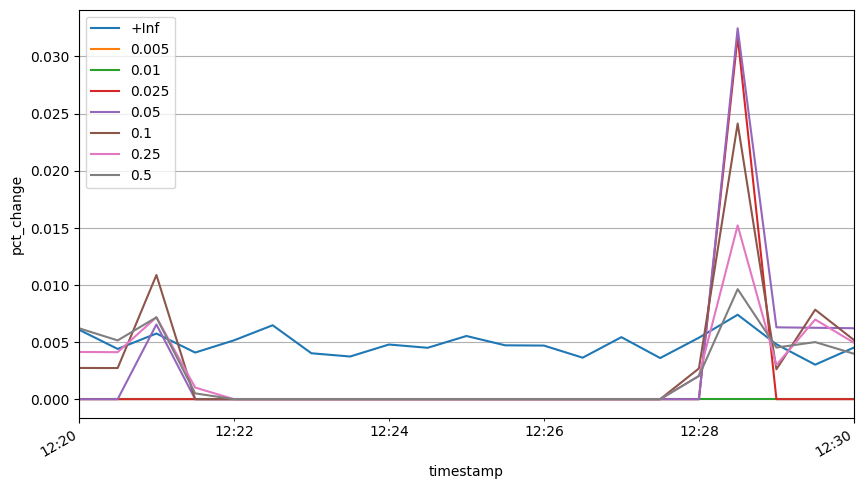

In [127]:

# Apply pct_change (relative change) for good fluctuations observer
root.query(abnormal_group)[["+Inf"] + [str(x) for x in BUCKETS]].pct_change().loc['2024-01-02 12:20:00':'2024-01-02 12:30:00'].plot(
    grid=True, figsize=(10, 6), ylabel="pct_change"
)
plt.gcf().autofmt_xdate()
plt.show()

Lúc này đã thấy rõ hơn được khoảng thời gian và những biến động về duration_time trong khoảng thời gian đó. Có thể thấy rằng trong khoảng thời gian từ 12:22 -> 12:28 thì các bucket đều không có biến động, ngoại trừ bucket +Inf. Ngoài khoảng này ra thì mọi biến động ở các bucket đều diễn ra bình thường.